In [77]:
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report , f1_score
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skompiler import skompile

from warnings import filterwarnings
filterwarnings('ignore')

In [78]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [79]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car



In [80]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [81]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    filtreted_missing_df = [missing_df['ratio'] < 3]
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    

In [82]:
# Load data and copy data called "df".
data = pd.read_csv("credit_risk_dataset.csv")
df = data.copy()
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [83]:
# Take base information about data .
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [84]:
# Check null values.
df.isnull().values.any()

True

In [85]:
# Total null values number . 
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [86]:
# Descriptive statistics about data . 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [87]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 32581
Variables: 12
cat_cols: 5
num_cols: 7
cat_but_car: 0
num_but_cat: 1


In [88]:
for col in num_cols:
    df = remove_outlier(df, col)

In [89]:
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [90]:
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'loan_status']

In [91]:
# label_encoder = LabelEncoder()
# df[cat_cols] = df[cat_cols].apply(label_encoder.fit_transform)

In [92]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32114.0,27.496606,5.708742,20.00,23.00,26.00,30.00,57.00
person_income,32114.0,62938.555116,34946.561273,4000.00,38400.00,55000.00,78000.00,240000.00
person_emp_length,31224.0,4.748687,3.958351,0.00,2.00,4.00,7.00,25.00
loan_amnt,32114.0,9513.865448,6234.312006,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,29044.0,11.003750,3.238936,5.42,7.90,10.99,13.47,23.22
loan_status,32114.0,0.218752,0.413406,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32114.0,0.171112,0.106329,0.01,0.09,0.15,0.23,0.72
cb_person_cred_hist_length,32114.0,5.666843,3.767404,2.00,3.00,4.00,8.00,24.00


In [93]:
missing_values_table(df)

                   n_miss  ratio
loan_int_rate        3070   9.56
person_emp_length     890   2.77


In [94]:
#person_emp_length boş dpğer oranı düşük olduğu için veri setinden çıkarttım.
df = df.dropna(subset=['person_emp_length'])
df.shape

(31224, 12)

In [95]:
#eksik olan kredi notunu gelir ve kredi harf notu doğrultusunda ortalama alıp değiştirdim. Eksik olanları düşürdüm.
df['loan_int_rate'] = df.groupby(['person_income', 'loan_grade'])['loan_int_rate'].transform(lambda x: x.fillna(x.mean()))
df = df.dropna(subset=['loan_int_rate'])
df.shape

(30735, 12)

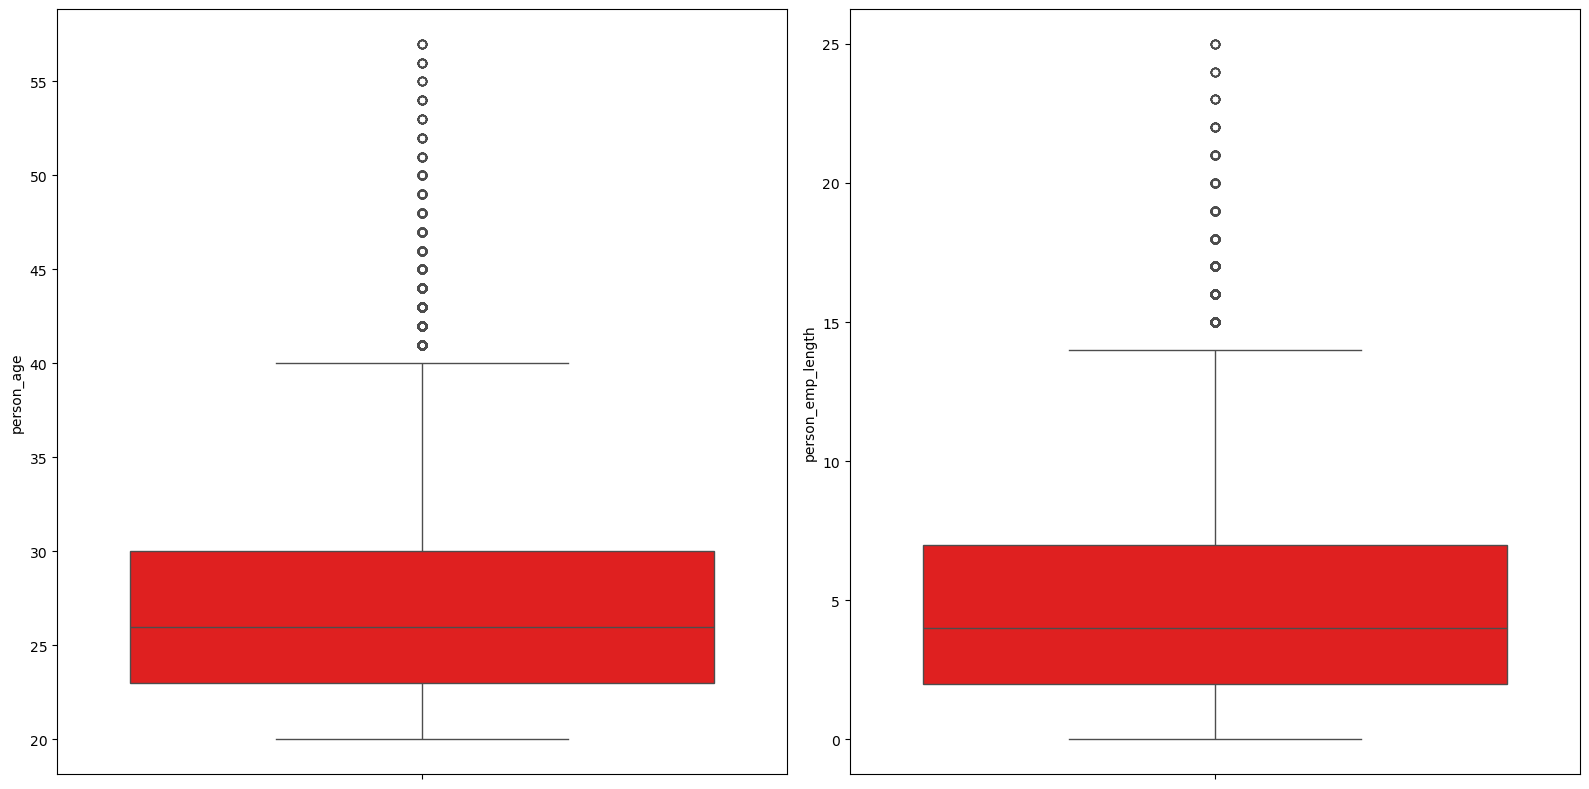

In [96]:
# Looking at the chart after outliers are removed .
features = ['person_age', 'person_emp_length']

plt.figure(figsize=(16, 8))

for i in range(len(features)):
  plt.subplot(1, len(features), i + 1)
  sns.boxplot(data=df, y=features[i], color='red')
  plt.tight_layout()

plt.show()

In [97]:
# Again control what are they null values ?
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [98]:
# After drop outliers
mean_person_emp_length = df['person_emp_length'].mean()
mean_loan_int_rate = df['loan_int_rate'].mean()

print("Mean Person Employee Length : " , mean_person_emp_length)
print("Mean Load Int Rate : " , mean_loan_int_rate)

Mean Person Employee Length :  4.741369773873434
Mean Load Int Rate :  11.025049239646897


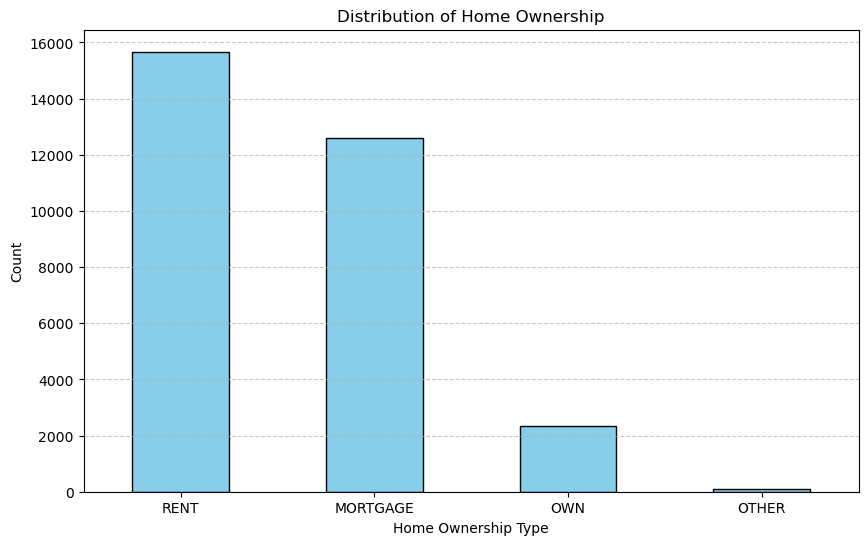

In [99]:
# Bar Plot for person_home_ownership
plt.figure(figsize=(10, 6))
df['person_home_ownership'].value_counts().plot.bar(color='skyblue', edgecolor='black')
plt.title('Distribution of Home Ownership')
plt.xlabel('Home Ownership Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


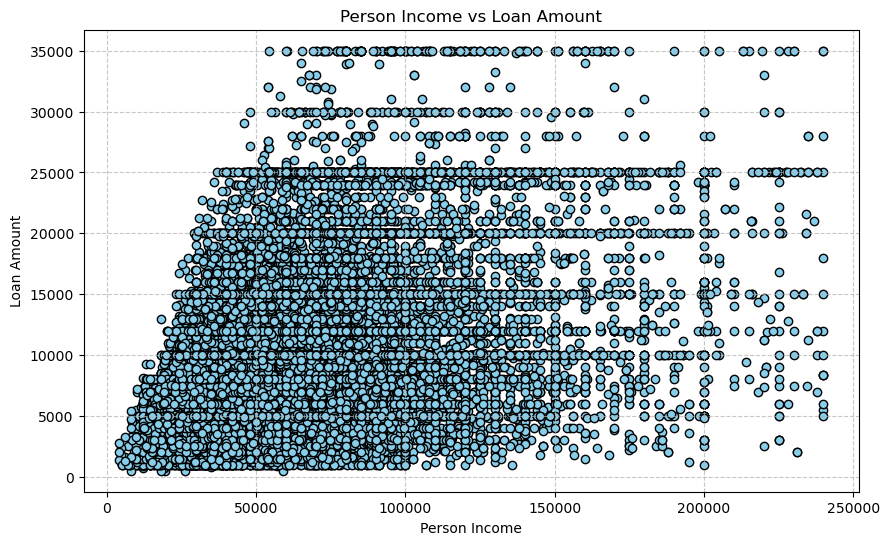

In [100]:
# Scatter Plot for person_income vs loan_amnt
plt.figure(figsize=(10, 6))
plt.scatter(df['person_income'], df['loan_amnt'], color='skyblue', edgecolor='black')
plt.title('Person Income vs Loan Amount')
plt.xlabel('Person Income')
plt.ylabel('Loan Amount')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


<Figure size 1000x600 with 0 Axes>

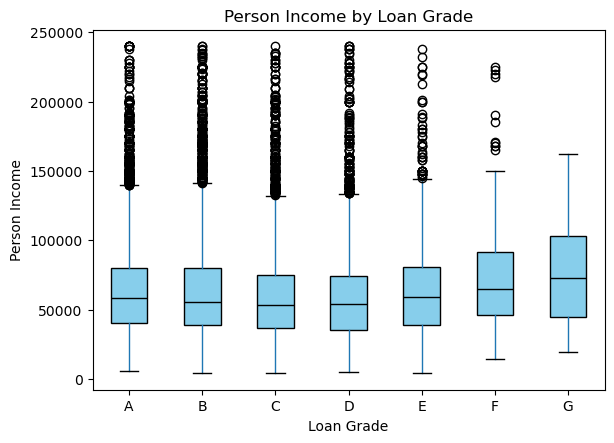

In [101]:
# Box Plot for person_income by loan_grade
plt.figure(figsize=(10, 6))
df.boxplot(column='person_income', by='loan_grade', grid=False, patch_artist=True,
           boxprops=dict(facecolor='skyblue', color='black'),
           medianprops=dict(color='black'))
plt.title('Person Income by Loan Grade')
plt.suptitle('')
plt.xlabel('Loan Grade')
plt.ylabel('Person Income')
plt.show()


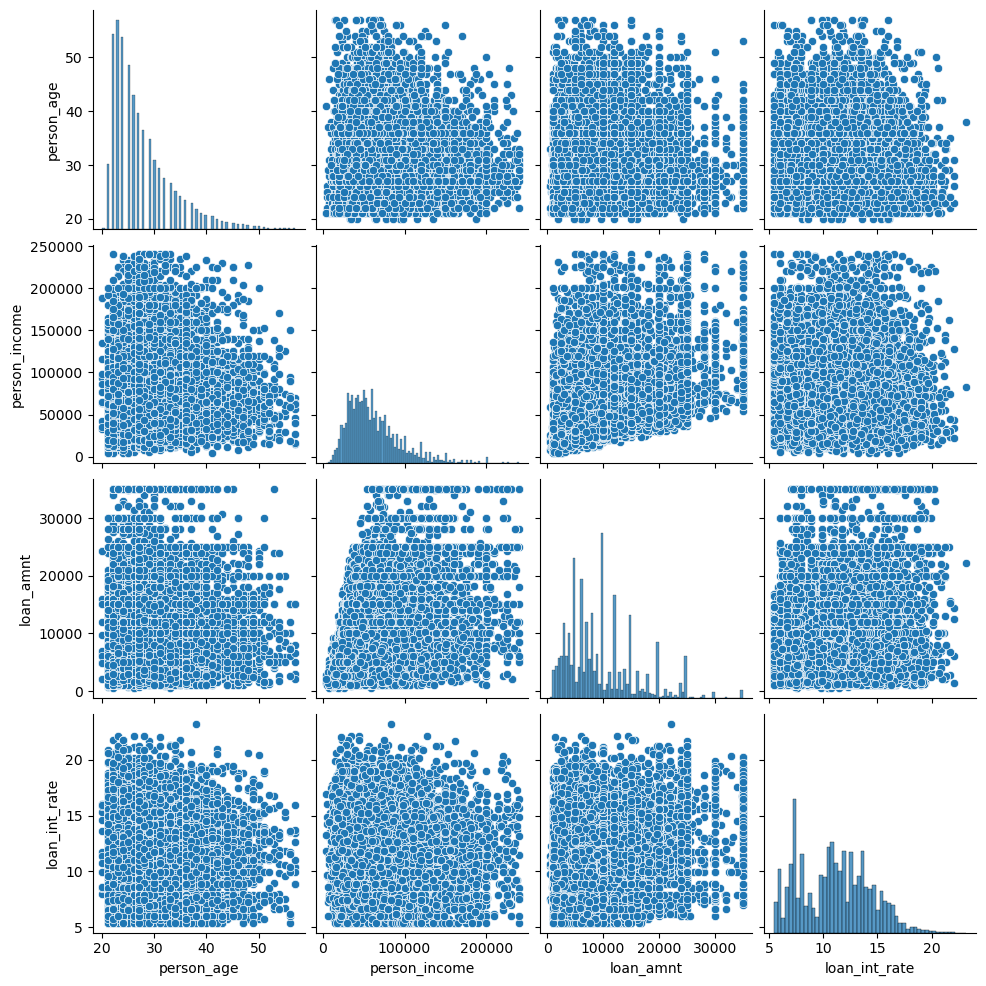

In [102]:
# Pair Plot for numerical variables
sns.pairplot(df[['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']])
plt.show()


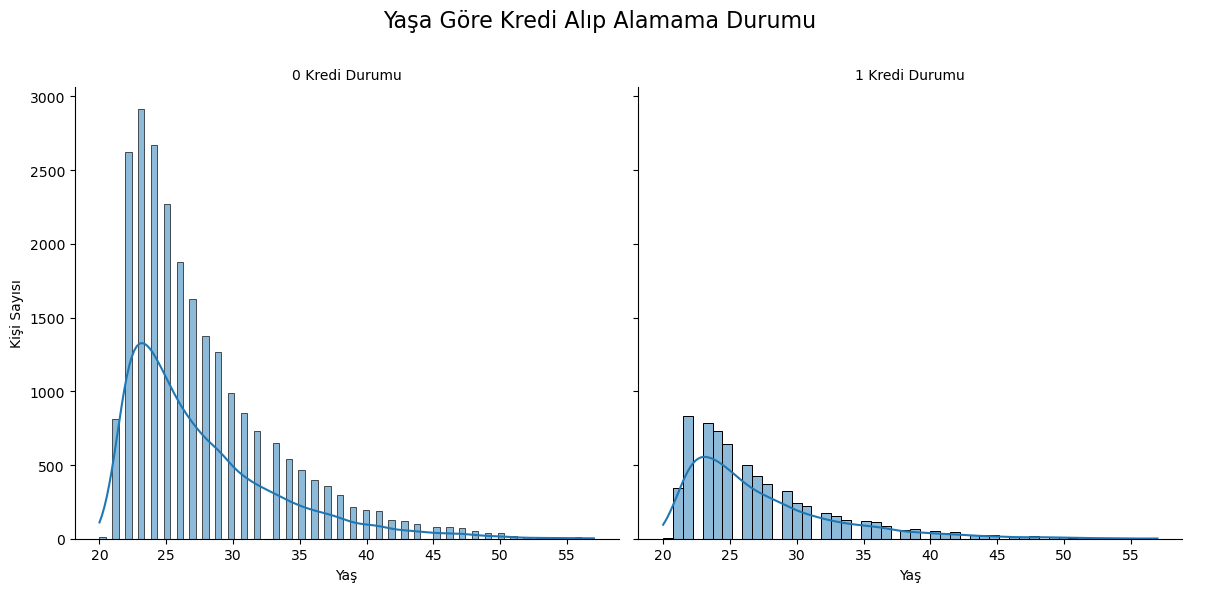

In [103]:
g = sns.FacetGrid(df, col="loan_status", height=6, aspect=1)
g.map(sns.histplot, "person_age", kde=True)
g.set_axis_labels("Yaş", "Kişi Sayısı")
g.set_titles(col_template="{col_name} Kredi Durumu")
g.add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Yaşa Göre Kredi Alıp Alamama Durumu', fontsize=16)
plt.show()

In [104]:
label_encoder = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(label_encoder.fit_transform)

In [105]:
df["loan_status"].value_counts()


loan_status
0    24112
1     6623
Name: count, dtype: int64

In [106]:
# Control
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30735 entries, 1 to 32577
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  30735 non-null  int64  
 1   person_income               30735 non-null  int64  
 2   person_home_ownership       30735 non-null  int32  
 3   person_emp_length           30735 non-null  float64
 4   loan_intent                 30735 non-null  int32  
 5   loan_grade                  30735 non-null  int32  
 6   loan_amnt                   30735 non-null  int64  
 7   loan_int_rate               30735 non-null  float64
 8   loan_status                 30735 non-null  int64  
 9   loan_percent_income         30735 non-null  float64
 10  cb_person_default_on_file   30735 non-null  int32  
 11  cb_person_cred_hist_length  30735 non-null  int64  
dtypes: float64(3), int32(4), int64(5)
memory usage: 2.6 MB


In [107]:
df["Ratio of Age to Income"] = df["person_age"] / df["person_income"]

In [108]:
df['Ratio of Loan Amount to Age'] = df["loan_amnt"] / df["person_age"]

In [109]:
df['Ratio'] = (df["loan_amnt"] * df['loan_int_rate']) / df['person_income']

In [110]:
df["Ratio of Grade to Amount"] = df["loan_grade"] / df["loan_amnt"] 

In [111]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'Ratio of Age to Income', 'Ratio of Loan Amount to Age', 'Ratio',
       'Ratio of Grade to Amount'],
      dtype='object')

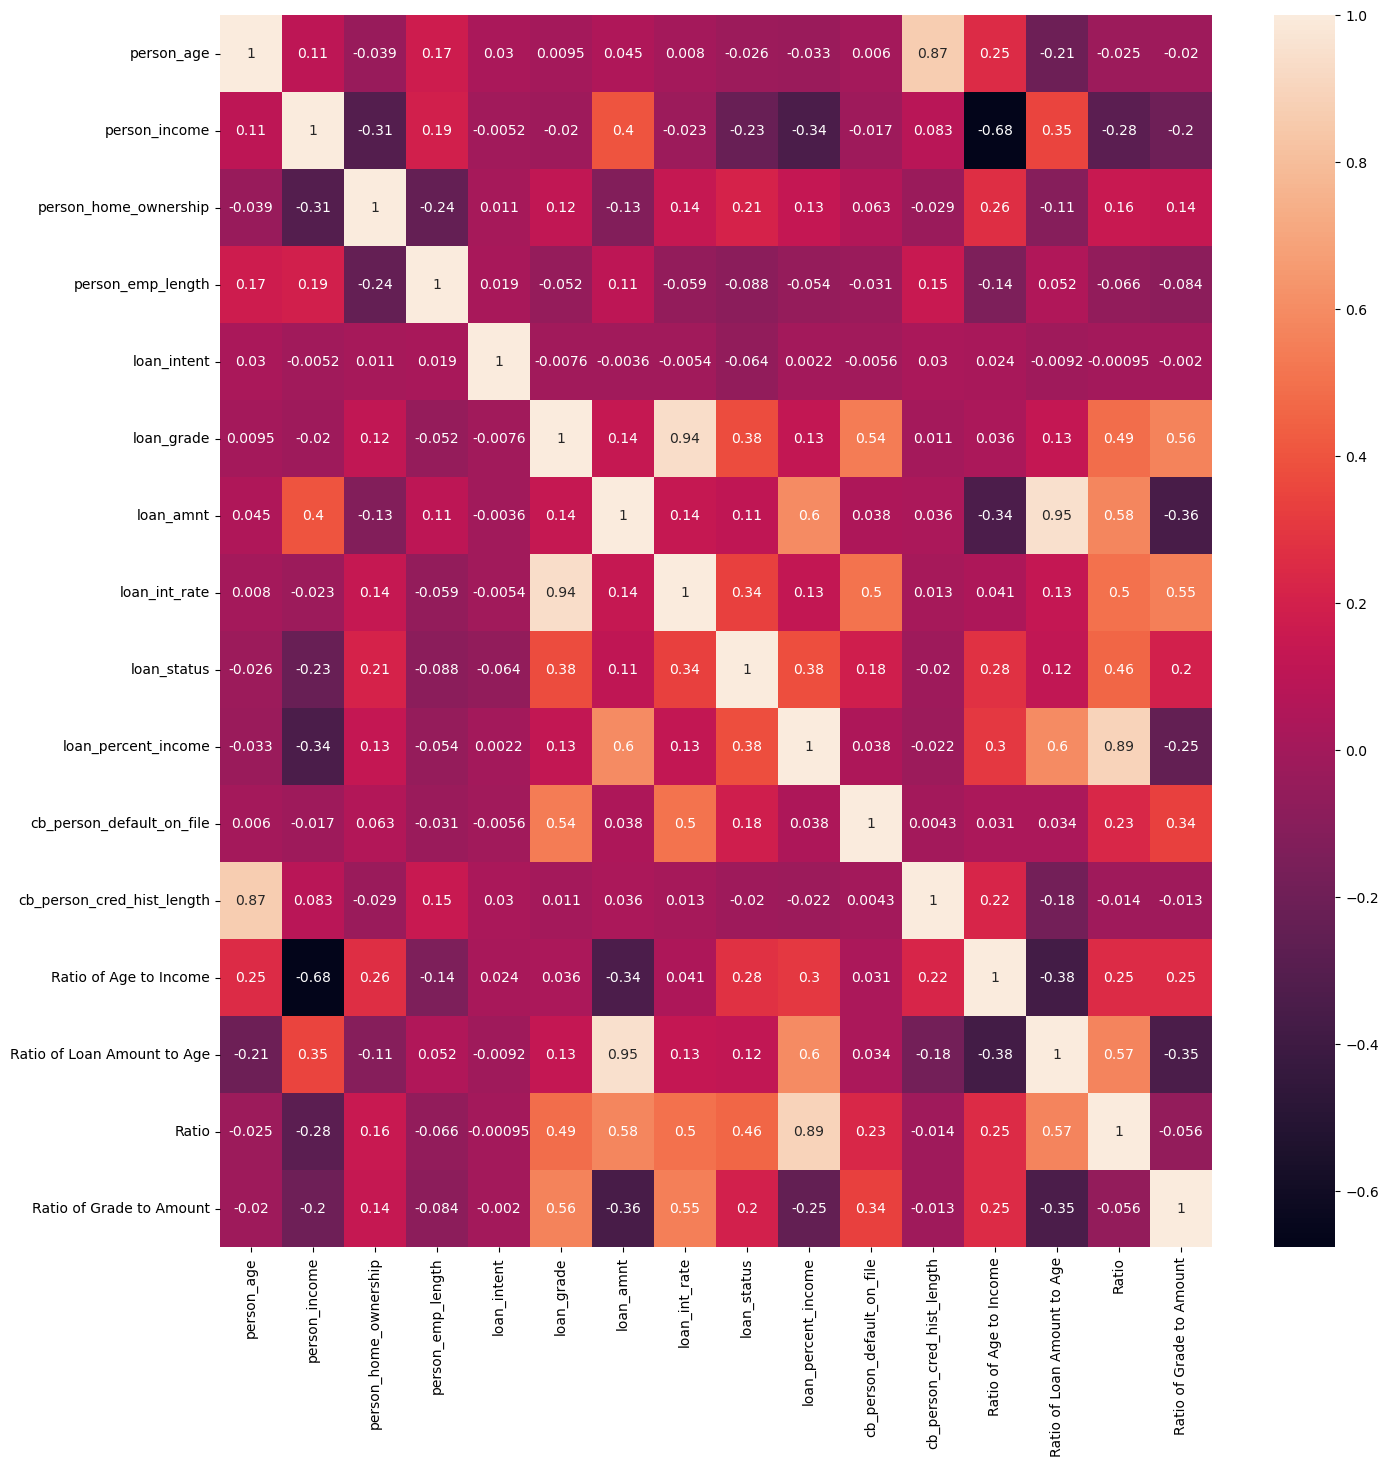

In [112]:
heat_map_continuous = df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(heat_map_continuous, annot=True)
plt.show()


In [113]:
# Train - test split data . I select test_size = 0.20 
y = df["loan_status"]
X = df.drop(["loan_status"] , axis = 1)
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.20 , random_state = 42)

In [114]:
X_train.shape

(24588, 15)

In [115]:
y_train.shape

(24588,)

In [116]:
# Synthetic data - I wanted to prevent unbalanced data in the training dataset.

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [117]:
X_resampled[0:5]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Ratio of Age to Income,Ratio of Loan Amount to Age,Ratio,Ratio of Grade to Amount
0,25,55000,0,3.0,0,0,24200,8.49,0.44,0,3,0.000455,968.000000,3.735600,0.0000
1,24,65000,0,8.0,2,0,2000,5.42,0.03,0,3,0.000369,83.333333,0.166769,0.0000
2,25,44000,3,9.0,3,2,10000,12.68,0.23,1,4,0.000568,400.000000,2.881818,0.0002
3,26,37500,0,4.0,0,0,7000,6.54,0.19,0,4,0.000693,269.230769,1.220800,0.0000
4,25,80208,0,1.0,3,0,4000,5.42,0.05,0,3,0.000312,160.000000,0.270297,0.0000


In [118]:
y_resampled.shape

(38456,)

In [119]:
# Control
y_resampled.shape

(38456,)

# Logistic Regression

In [120]:
# Setup Logistic Regression model 
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X_resampled, y_resampled)

In [121]:
# Control
loj_model

LogisticRegression(solver='liblinear')

In [122]:
# Intercept of Logistic Regression model
loj_model.intercept_

array([-0.00050805])

In [123]:
# Coefficients of Logistic Regression model
loj_model.coef_

array([[-5.28612341e-02, -2.97280571e-05,  2.70544123e-02,
        -3.45600714e-02, -5.80491669e-02,  6.23246063e-02,
         2.72049390e-04,  1.98300374e-01,  1.97741242e-03,
        -6.91928593e-04, -3.41774695e-02,  9.60212160e-06,
        -4.70655695e-03,  5.50913587e-02,  1.57363708e-05]])

In [124]:
# Prediction 
y_pred = loj_model.predict(X_test)

In [125]:
confusion_matrix(y_test , y_pred)

array([[3511, 1373],
       [ 329,  934]], dtype=int64)

In [126]:
# Score of Logistic Regression Model
loj_model_accuracy = accuracy_score(y_test , y_pred)
loj_model_accuracy

0.7231169676264845

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      4884
           1       0.40      0.74      0.52      1263

    accuracy                           0.72      6147
   macro avg       0.66      0.73      0.66      6147
weighted avg       0.81      0.72      0.75      6147



In [128]:
loj_model_f1 = f1_score(y_test , y_pred)

# Gaussian Naive Bayes

In [129]:
# Setup Gaussian Naive Bayes model and control
nb = GaussianNB()
nb_model = nb.fit(X_resampled, y_resampled)
nb_model

GaussianNB()

In [130]:
nb_model.predict(X_test)[0:20]

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
      dtype=int64)

In [131]:
# Prediction
y_pred = nb_model.predict(X_test)

In [132]:
# Score of Gaussian Naive Bayes
nb_model_accuracy = accuracy_score(y_test , y_pred)
nb_model_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)


              precision    recall  f1-score   support

           0       0.90      0.75      0.82      4884
           1       0.41      0.68      0.51      1263

    accuracy                           0.73      6147
   macro avg       0.65      0.71      0.66      6147
weighted avg       0.80      0.73      0.75      6147



array([[3659, 1225],
       [ 410,  853]], dtype=int64)

In [133]:
nb_model_f1 = f1_score(y_test , y_pred)

# KNN

In [134]:
# Setup KNN model and control
knn = KNeighborsClassifier()
knn_model = knn.fit(X_resampled, y_resampled)
knn_model

KNeighborsClassifier()

In [135]:
y_pred = knn_model.predict(X_test)

In [136]:
# First score of KNN model
knn_model_accuracy = accuracy_score(y_test , y_pred)
knn_model_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      4884
           1       0.45      0.68      0.55      1263

    accuracy                           0.77      6147
   macro avg       0.68      0.74      0.69      6147
weighted avg       0.81      0.77      0.78      6147



array([[3841, 1043],
       [ 399,  864]], dtype=int64)

## Model Tuning

In [137]:
# This is hyparparameter find process . For KNN model , I want to "n_neighbors" value and I use CV method.
knn_params = {"n_neighbors" : np.arange(1,50)}

In [138]:
knn = KNeighborsClassifier()

In [139]:
# I use 10 layer CV .
knn_cv = GridSearchCV(knn , knn_params , cv = 10)

In [140]:
knn_cv.fit(X_resampled, y_resampled)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [141]:
print("Best score:" + str(knn_cv.best_score_))
print("Best parameters: " + str(knn_cv.best_params_))

Best score:0.8611411312109182
Best parameters: {'n_neighbors': 1}


In [142]:
knn = KNeighborsClassifier(1)
knn_tuned = knn.fit(X_resampled, y_resampled)

In [143]:
y_pred = knn_tuned.predict(X_test)

In [144]:
knn_tuned_model_accuracy =  accuracy_score(y_test, y_pred)
knn_tuned_model_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4884
           1       0.50      0.64      0.57      1263

    accuracy                           0.80      6147
   macro avg       0.70      0.74      0.72      6147
weighted avg       0.82      0.80      0.81      6147



array([[4081,  803],
       [ 449,  814]], dtype=int64)

In [145]:
knn_tuned_f1 = f1_score(y_test , y_pred)

# MLP Classifier

This is a basic neural networks model with scikit-learn . Assigment doesn't include topics about deep learning frameworks but I want to try neural networks with scikit-learn.

In [146]:
# This line of code creates a "scaler" object to standardize the data features using the "StandardScaler."
scaler = StandardScaler()

In [147]:
scaler.fit(X_resampled, y_resampled)
X_train_scaled = scaler.transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [148]:
X_test_scaled[0:5]

array([[-0.96500628, -0.62575519, -1.345857  , -1.21531728,  0.42117934,
        -1.18415492,  0.73422265, -1.02642103,  1.73941423, -0.41908113,
        -0.96802298, -0.09251231,  1.18742012,  0.63817043, -0.71316724],
       [ 0.89371409, -0.8733662 ,  0.85183065, -0.40517132,  1.640502  ,
        -0.33613426, -0.52231534, -0.44036694,  0.25463434, -0.41908113,
         1.00641267,  1.12952296, -0.67963724,  0.02199389, -0.27021482],
       [-0.59326221, -0.30150268,  0.85183065,  0.40497465, -0.79814333,
         0.51188641, -0.77967854,  0.41377571, -0.81770668,  2.38617282,
        -0.40389851, -0.31299848, -0.68375382, -0.62531195,  0.47394523],
       [-0.77913424,  2.35147242,  0.85183065, -0.94526863, -0.79814333,
         1.35990707, -0.77967854,  0.97489132, -1.31263331, -0.41908113,
        -0.96802298, -1.08994976, -0.64795745, -1.12760189,  1.06750146],
       [-0.22151813, -0.53732268,  0.85183065, -0.94526863,  1.03084067,
        -0.33613426,  0.28005229, -0.06317256, 

In [149]:
# Setup MLP Classifier model and control
mlpc = MLPClassifier().fit(X_train_scaled , y_resampled)
MLPClassifier()

MLPClassifier()

In [150]:
y_pred = mlpc.predict(X_test_scaled)
mlp_first_accuracy = accuracy_score(y_test , y_pred)
mlp_first_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4884
           1       0.66      0.72      0.69      1263

    accuracy                           0.87      6147
   macro avg       0.80      0.81      0.80      6147
weighted avg       0.87      0.87      0.87      6147



array([[4425,  459],
       [ 354,  909]], dtype=int64)

## Model Tuning

In [151]:
# Tuning for the some most known parameters that will affect the accuracy of the model .
mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (5,3),
                                     (3,5)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic","tanh"],
              "learning_rate": ["constant", "invscaling", "adaptive"]}


In [152]:
# I use 2 layers CV for model tuning.
mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 2, 
                         n_jobs = -1,
                         verbose = 2)

mlpc_cv_model.fit(X_train_scaled, y_resampled)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'alpha': [0.1, 0.01, 0.02, 0.005],
                         'hidden_layer_sizes': [(10, 10, 10), (100, 100, 100),
                                                (100, 100), (5, 3), (3, 5)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'adam', 'sgd']},
             verbose=2)

In [153]:
mlpc_cv_model.best_params_

{'activation': 'tanh',
 'alpha': 0.01,
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [154]:
mlpc_tuned = MLPClassifier(activation = "tanh", 
                           alpha = 0.01, 
                           hidden_layer_sizes = (100,100),
                           solver = "adam",
                           learning_rate="invscaling")

In [155]:
mlpc_tuned.fit(X_train_scaled, y_resampled)
y_pred = mlpc_tuned.predict(X_test_scaled)
mlp_tuned_accuracy = accuracy_score(y_test, y_pred)
mlp_tuned_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4884
           1       0.71      0.72      0.72      1263

    accuracy                           0.88      6147
   macro avg       0.82      0.82      0.82      6147
weighted avg       0.88      0.88      0.88      6147



array([[4519,  365],
       [ 355,  908]], dtype=int64)

In [156]:
mlp_tuned_f1 = f1_score(y_test , y_pred)

# CART

In [157]:
# Setup CART model and control
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_resampled, y_resampled)
cart_model


DecisionTreeClassifier()

In [158]:
#pip install astor


In [159]:
print(skompile(cart_model.predict).to("python/code"))

(((((((0 if x[10] <= 3.5 else 1) if x[4] <= 0.5 else 0) if x[0] <= 27.5 else
    (0 if x[2] <= 1.5 else 1) if x[11] <= 0.0018281249795109034 else 0) if 
    x[8] <= 0.1550000011920929 else 1) if x[1] <= 19998.0 else ((((((((((((
    (0 if x[1] <= 28500.0 else 0 if x[0] <= 21.5 else 0 if x[7] <= 
    6.325000047683716 else 1) if x[1] <= 31600.0 else (1 if x[10] <= 3.5 else
    0) if x[7] <= 5.605000019073486 else 0 if x[13] <= 0.35491175949573517 else
    1 if x[13] <= 0.36073707044124603 else 0) if x[8] <= 
    0.06499999947845936 else (0 if x[7] <= 7.06499981880188 else 1) if x[7] <=
    7.5 else 0) if x[4] <= 0.5 else (0 if x[11] <= 0.0006144154176581651 else
    1 if x[11] <= 0.0006208108097780496 else ((0 if x[12] <= 
    42.261905670166016 else (0 if x[13] <= 0.22539053112268448 else 1) if x
    [7] <= 7.3450000286102295 else 0) if x[12] <= 46.03174591064453 else 0) if
    x[12] <= 79.0625 else 1 if x[12] <= 80.80356979370117 else 0 if x[2] <=
    2.5 else 0 if x[7] <= 7.077636718

In [160]:
y_pred = cart_model.predict(X_test)
cart_accuracy = accuracy_score(y_test, y_pred)
cart_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4884
           1       0.59      0.74      0.65      1263

    accuracy                           0.84      6147
   macro avg       0.76      0.80      0.77      6147
weighted avg       0.86      0.84      0.85      6147



array([[4230,  654],
       [ 334,  929]], dtype=int64)

## Model Tuning

In [161]:
cart_grid = {"max_depth": range(1,15),
            "min_samples_split" : list(range(2,50)) }

In [162]:
cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }
cart = tree.DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 10, n_jobs = -1, verbose = 2)
cart_cv_model = cart_cv.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


In [163]:
cart_cv_model.best_params_

{'max_depth': 9, 'min_samples_split': 2}

In [164]:
cart_tuned = tree.DecisionTreeClassifier(max_depth = 9 , min_samples_split = 2)

In [165]:
cart_tuned.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=9)

In [166]:
y_pred = cart_tuned.predict(X_test)

In [167]:
cart_tuned_accuracy = accuracy_score(y_test , y_pred)
cart_tuned_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4884
           1       0.64      0.73      0.68      1263

    accuracy                           0.86      6147
   macro avg       0.78      0.81      0.79      6147
weighted avg       0.87      0.86      0.86      6147



array([[4355,  529],
       [ 342,  921]], dtype=int64)

In [168]:
cart_tuned_f1 = f1_score(y_test , y_pred)

# Random Forest

In [169]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_resampled, y_resampled)

In [170]:
y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test , y_pred)
rf_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4884
           1       0.74      0.75      0.75      1263

    accuracy                           0.90      6147
   macro avg       0.84      0.84      0.84      6147
weighted avg       0.90      0.90      0.90      6147



array([[4558,  326],
       [ 316,  947]], dtype=int64)

## Model Tuning

In [171]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

In [172]:
rf_model = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf_model,
                          rf_params,
                          cv = 10,
                          n_jobs = -1,
                          verbose = 2)

In [173]:
rf_cv_model.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 10], 'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             verbose=2)

In [174]:
rf_cv_model.best_params_

{'max_depth': 10,
 'max_features': 8,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [175]:
rf_tuned = RandomForestClassifier(max_depth = 10 , max_features = 8,
                                 min_samples_split = 2 , n_estimators = 1000)
rf_tuned.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=10, max_features=8, n_estimators=1000)

In [176]:
y_pred = rf_tuned.predict(X_test)
rf_tuned_accuracy = accuracy_score(y_test , y_pred)
rf_tuned_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4884
           1       0.69      0.74      0.71      1263

    accuracy                           0.88      6147
   macro avg       0.81      0.83      0.82      6147
weighted avg       0.88      0.88      0.88      6147



array([[4461,  423],
       [ 329,  934]], dtype=int64)

In [177]:
rf_tuned_f1 = f1_score(y_test , y_pred)

# Gradient Boosting Machines

In [178]:
gbm = GradientBoostingClassifier()
gbm_model = gbm.fit(X_resampled, y_resampled)

In [179]:
y_pred = gbm_model.predict(X_test)
gbm_accuracy = accuracy_score(y_test , y_pred)
gbm_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4884
           1       0.70      0.74      0.72      1263

    accuracy                           0.88      6147
   macro avg       0.82      0.83      0.82      6147
weighted avg       0.88      0.88      0.88      6147



array([[4486,  398],
       [ 334,  929]], dtype=int64)

# Model Tuning

In [180]:
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

In [181]:
gbm = GradientBoostingClassifier()
gbm_cv_model = GridSearchCV(gbm , gbm_params , cv = 10 , n_jobs = -1)

In [182]:
gbm_cv_model.fit(X_resampled, y_resampled)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 100]})

In [183]:
gbm_cv_model.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_samples_split': 10,
 'n_estimators': 500}

In [184]:
gbm_tuned = GradientBoostingClassifier(learning_rate = 0.1,
                                      max_depth = 10,
                                      min_samples_split = 10,
                                      n_estimators = 500)
gbm_tuned.fit(X_resampled, y_resampled)

GradientBoostingClassifier(max_depth=10, min_samples_split=10, n_estimators=500)

In [185]:
y_pred = gbm_tuned.predict(X_test)
gbm_tuned_accuracy = accuracy_score(y_test , y_pred)
gbm_tuned_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4884
           1       0.91      0.76      0.83      1263

    accuracy                           0.94      6147
   macro avg       0.93      0.87      0.90      6147
weighted avg       0.93      0.94      0.93      6147



array([[4790,   94],
       [ 300,  963]], dtype=int64)

In [186]:
gbm_tuned_f1 = f1_score(y_test , y_pred)

# XGBoost

In [187]:
xgb_model = XGBClassifier().fit(X_resampled, y_resampled)

In [188]:
y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4884
           1       0.88      0.73      0.79      1263

    accuracy                           0.92      6147
   macro avg       0.91      0.85      0.87      6147
weighted avg       0.92      0.92      0.92      6147



array([[4757,  127],
       [ 346,  917]], dtype=int64)

## Model Tuning

In [189]:
xgb_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_samples_split": [2,5,10]}

In [190]:
xgb = XGBClassifier()
xgb_cv_model = GridSearchCV(xgb , xgb_params , cv = 10 , n_jobs = -1)

In [191]:
xgb_cv_model.fit(X_resampled, y_resampled)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500, 1000, 2000],
                         'subsample': [0.6, 0.8, 1.0]})

In [192]:
xgb_cv_model.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_samples_split': 2,
 'n_estimators': 2000,
 'subsample': 0.8}

In [193]:
xgb_tuned = XGBClassifier(learning_rate = 0.01,
                        max_depth = 6,
                        min_samples_split = 2,
                        n_estimators = 2000,
                        subsample = 0.8)
xgb_tuned.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, num_parallel_tree=None, ...)

In [194]:
y_pred = xgb_tuned.predict(X_test)
xgbm_tuned_accuracy = accuracy_score(y_test, y_pred)
xgbm_tuned_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4884
           1       0.88      0.74      0.80      1263

    accuracy                           0.93      6147
   macro avg       0.91      0.86      0.88      6147
weighted avg       0.92      0.93      0.92      6147



array([[4760,  124],
       [ 334,  929]], dtype=int64)

In [195]:
xgbm_tuned_f1 = f1_score(y_test , y_pred)

# LightGBM

In [196]:
lgbm_model = LGBMClassifier().fit(X_resampled, y_resampled)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19228, number of negative: 19228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 38456, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [197]:
y_test

3493     0
22189    0
5065     0
17072    1
12388    0
        ..
15648    0
22566    0
28065    0
158      0
10600    0
Name: loan_status, Length: 6147, dtype: int64

In [198]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMClassifier

# Örnek veriler
# X_resampled, y_resampled = np.random.rand(100, 10), np.random.randint(0, 2, 100)  # Kendi verinizi burada kullanın

# K-Fold çapraz doğrulama parametreleri
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# LGBMClassifier modeli
model = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.1,
    num_leaves=31,
    min_data_in_leaf=20,
    verbose=-1
)

# Çapraz doğrulama
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

# Ortalama CV puanını yazdır
mean_cv_score = np.mean(cv_scores)
print(f'Ortalama CV Skoru: {mean_cv_score:.4f}')


Ortalama CV Skoru: 0.9353


In [199]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

# Örnek veriler
# X, y = np.random.rand(100, 10), np.random.randint(0, 2, 100)  # Kendi verinizi burada kullanın

# Veriyi eğitim ve test olarak ayır
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NumPy dizilerine dönüştür
X_train_full = np.array(X_train_full)
X_test = np.array(X_test)
y_train_full = np.array(y_train_full)
y_test = np.array(y_test)

# K-Fold çapraz doğrulama parametreleri
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# LGBMClassifier modeli
model = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.1,
    num_leaves=31,
    min_data_in_leaf=20,
    verbose=-1
)

# Çapraz doğrulama sonuçlarını saklamak için
cv_scores = []
classification_reports = []
confusion_matrices = []

# K-Fold çapraz doğrulama
for train_index, val_index in kf.split(X_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Modeli eğit
    model.fit(X_train, y_train)

    # Tahmin yap
    y_pred = model.predict(X_val)

    # Doğruluk hesapla ve raporla
    lgbm_accuracy = accuracy_score(y_val, y_pred)
    cv_scores.append(lgbm_accuracy)
    
    # Sınıflandırma raporu ve karışıklık matrisi
    classification_reports.append(classification_report(y_val, y_pred))
    confusion_matrices.append(confusion_matrix(y_val, y_pred))

# Ortalama CV puanını yazdır
mean_cv_score = np.mean(cv_scores)
print(f'Ortalama CV Skoru: {mean_cv_score:.4f}')

# Her kat için sınıflandırma raporunu ve karışıklık matrisini yazdır
for i, (report, matrix) in enumerate(zip(classification_reports, confusion_matrices)):
    print(f'\nFold {i+1} Classification Report:\n{report}')
    print(f'Fold {i+1} Confusion Matrix:\n{matrix}')

# Modeli tüm eğitim verisi ile eğit
model.fit(X_train_full, y_train_full)

# Test setinde tahmin yap
y_pred_test = model.predict(X_test)

# Test seti için doğruluk, sınıflandırma raporu ve karışıklık matrisini yazdır
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Seti Accuracy: {test_accuracy:.4f}')
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


Ortalama CV Skoru: 0.9359

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1904
           1       0.97      0.72      0.83       555

    accuracy                           0.93      2459
   macro avg       0.95      0.86      0.89      2459
weighted avg       0.93      0.93      0.93      2459

Fold 1 Confusion Matrix:
[[1891   13]
 [ 155  400]]

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1904
           1       0.96      0.73      0.83       555

    accuracy                           0.93      2459
   macro avg       0.94      0.86      0.89      2459
weighted avg       0.93      0.93      0.93      2459

Fold 2 Confusion Matrix:
[[1886   18]
 [ 148  407]]

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1935
           1  

In [200]:
y_pred = lgbm_model.predict(X_test)
lgbm_accuracy = accuracy_score(y_test, y_pred)
lgbm_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4884
           1       0.88      0.73      0.80      1263

    accuracy                           0.92      6147
   macro avg       0.91      0.85      0.87      6147
weighted avg       0.92      0.92      0.92      6147



array([[4757,  127],
       [ 344,  919]], dtype=int64)

## Model Tuning

In [201]:
lgbm_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_child_samples": [5,10,20]}

In [202]:
lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose = 2)

In [203]:
lgbm_cv_model.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19228, number of negative: 19228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 38456, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

GridSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_samples': [5, 10, 20],
                         'n_estimators': [100, 500, 1000, 2000],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [204]:
lgbm_cv_model.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_samples': 10,
 'n_estimators': 2000,
 'subsample': 0.6}

In [205]:
lgbm = LGBMClassifier(learning_rate = 0.1, 
                       max_depth = 6,
                       subsample = 0.6,
                       n_estimators = 1000,
                       min_child_samples = 10)

In [206]:
lgbm_tuned = lgbm.fit(X_resampled, y_resampled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19228, number of negative: 19228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 38456, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [207]:
y_pred = lgbm_tuned.predict(X_test)
lgbm_tuned_accuracy = accuracy_score(y_test, y_pred)
lgbm_tuned_accuracy
print(classification_report(y_test , y_pred))
confusion_matrix(y_test , y_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4884
           1       0.92      0.75      0.82      1263

    accuracy                           0.93      6147
   macro avg       0.93      0.87      0.89      6147
weighted avg       0.93      0.93      0.93      6147



array([[4799,   85],
       [ 318,  945]], dtype=int64)

In [208]:
lgbm_tuned_f1 = f1_score(y_test , y_pred)

# Result

In [209]:
# I created data frame called result. This data frame include accuracy score of all used models.

result = {'Model': ['LOJ', 'NB', 'KNN', 'MLP', 'CART',  'RF', 'GBM', 'XGBM', 'LGBM'],
        'Accuracy': np.array([loj_model_accuracy, nb_model_accuracy, knn_tuned_model_accuracy, 
                     mlp_tuned_accuracy, cart_tuned_accuracy, rf_tuned_accuracy, 
                     gbm_tuned_accuracy, xgbm_tuned_accuracy, lgbm_tuned_accuracy])*100}

result = pd.DataFrame(result)
result

,Model,Accuracy
0,LOJ,72.311697
1,NB,73.401659
2,KNN,79.632341
3,MLP,88.286969
4,CART,85.830486
5,RF,87.766390
6,GBM,93.590369
7,XGBM,92.549211
8,LGBM,93.443956


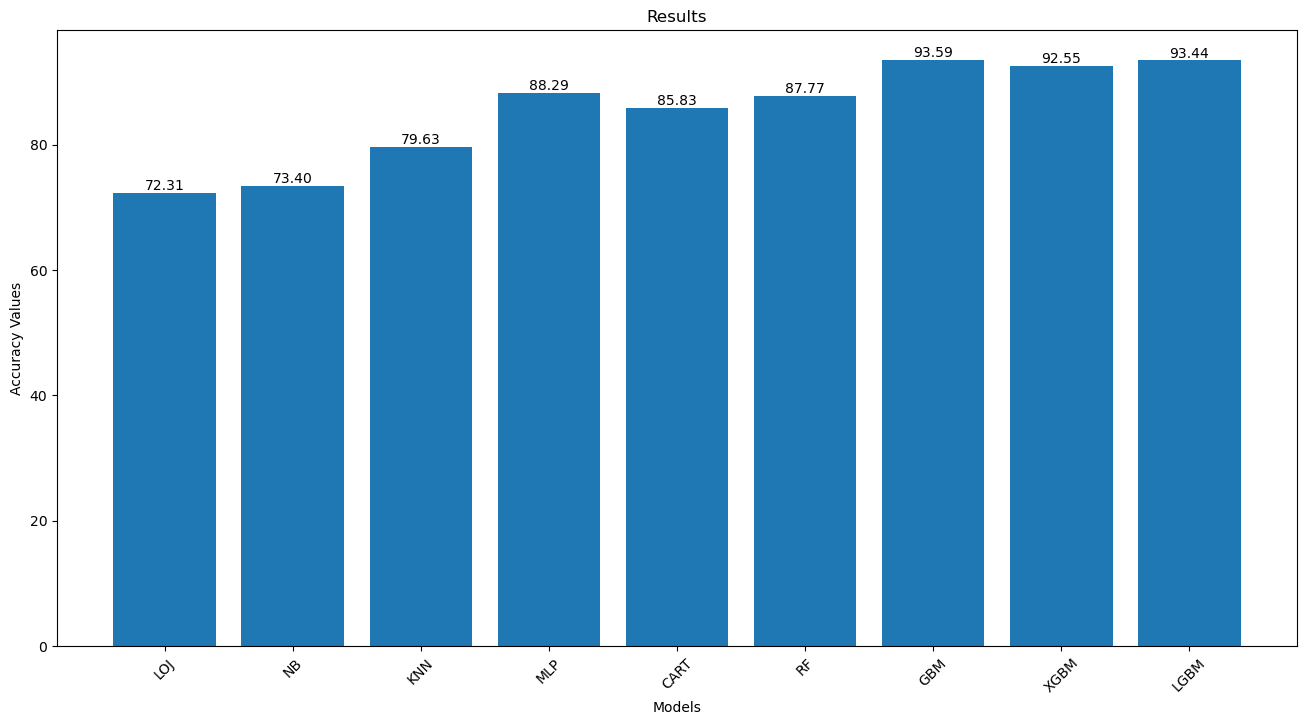

In [210]:
plt.figure(figsize=(16, 8))

plt.bar(result['Model'], result['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy Values')
plt.title('Results')

for i, acc in enumerate(result['Accuracy']):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()


In [211]:
# I created data frame called result_f1. This data frame include accuracy score of all used models.

result_f1 = {'Model': ['LOJ', 'NB', 'KNN', 'MLP', 'CART',  'RF', 'GBM', 'XGBM', 'LGBM'],
        'F1': np.array([loj_model_f1, nb_model_f1, knn_tuned_f1, 
                     mlp_tuned_f1, cart_tuned_f1, rf_tuned_f1, 
                     gbm_tuned_f1, xgbm_tuned_f1, lgbm_tuned_f1])*100}

result_f1 = pd.DataFrame(result_f1)
result_f1

,Model,F1
0,LOJ,52.324930
1,NB,51.062556
2,KNN,56.527778
3,MLP,71.608833
4,CART,67.895319
5,RF,71.297710
6,GBM,83.017241
7,XGBM,80.224525
8,LGBM,82.424771


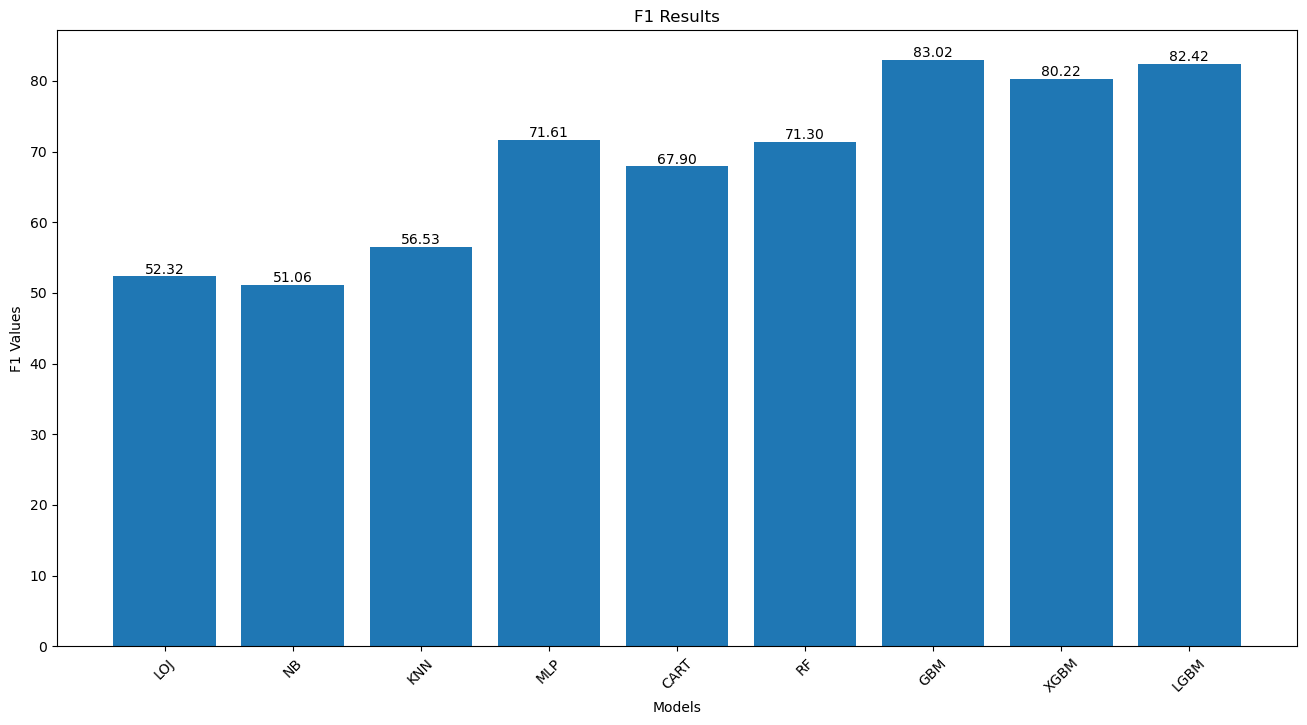

In [212]:
plt.figure(figsize=(16, 8))

plt.bar(result_f1['Model'], result_f1['F1'])
plt.xlabel('Models')
plt.ylabel('F1 Values')
plt.title('F1 Results')

for i, acc in enumerate(result_f1['F1']):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

F1 score and accuracy score results are shown in the graph and data frame above. Additionally, I also evaluated confusion matrices(TP , TN , FP , FN). Finally I decided the best model is LGBM model.

In [213]:
from joblib import dump, load

# Save model
dump(lgbm_tuned, 'predict_model_v2.joblib')


['predict_model_v2.joblib']